# Testing: Composite Stress Dataset Loader

This notebook tests the `CompositeStressDataset` class and ensures:
- Time-series inputs and targets are loaded correctly.
- Padding is applied as expected.
- Input/target shapes are suitable for model training.

In [2]:
import sys
import os

# Add src directory to Python path
project_root = os.path.abspath("..")  # Go up from /notebook
src_path = os.path.join(project_root, "src")
sys.path.append(src_path)
if src_path not in sys.path:
    sys.path.append(src_path)

In [3]:
from dataset import CompositeStressDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch

In [4]:
# Set paths
input_csv_path = os.path.join(project_root, "data", "IM78552_DATABASEInput.csv")
data_dir = os.path.join(project_root, "data", "_CSV")

# Load dataset
dataset = CompositeStressDataset(input_csv_path=input_csv_path, data_dir=data_dir, max_seq_len=1800)

## Dataset Summary

Let’s check the size of the dataset and inspect a sample to confirm correct parsing and formatting.

In [6]:
# Check dataset size
print(f"Number of samples: {len(dataset)}")

# Preview first item
x, y = dataset[0]
print("Input shape:", x.shape)   # Expected: [1800, 11]
print("Target shape:", y.shape)  # Expected: [1800, 6]

# Show first few time steps
print("\nSample Input (first 3 timesteps):\n", x[:3])
print("\nSample Output (first 3 timesteps):\n", y[:3])

Number of samples: 1848
Input shape: torch.Size([1800, 11])
Target shape: torch.Size([1800, 6])

Sample Input (first 3 timesteps):
 tensor([[ 0.0532,  0.0346,  0.0760,  0.1699,  0.1987,  0.1966, -3.1028,  1.5870,
          1.3570,  0.0000,  0.0000],
        [ 0.0479,  0.0346,  0.0760,  0.1699,  0.1987,  0.1966, -3.1028,  1.5870,
          1.3570,  0.0000,  0.0000],
        [ 0.0203,  0.0346,  0.0760,  0.1699,  0.1987,  0.1966, -3.1028,  1.5870,
          1.3570,  0.0000,  0.0000]])

Sample Output (first 3 timesteps):
 tensor([[0.0735, 0.0712, 0.2324, 0.1313, 0.1657, 0.1553],
        [0.0622, 0.0704, 0.2312, 0.1313, 0.1657, 0.1553],
        [0.0031, 0.0664, 0.2249, 0.1313, 0.1657, 0.1553]])


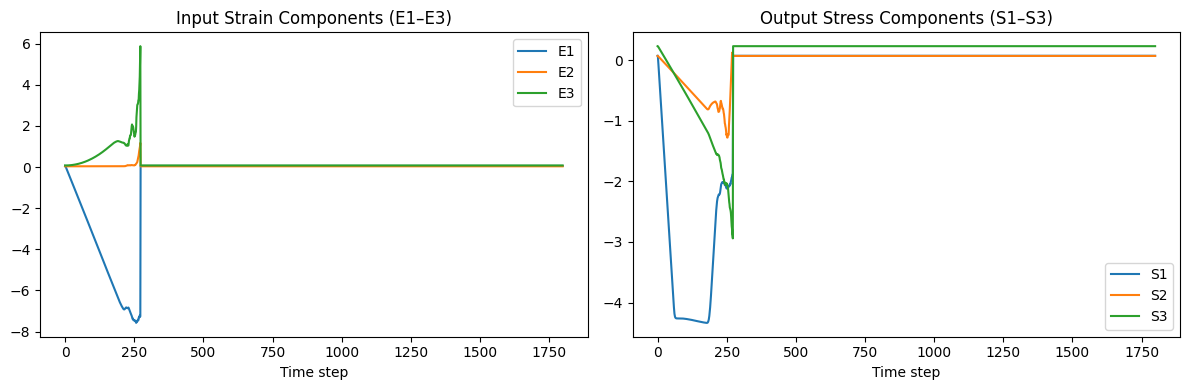

In [7]:
# Plot a few features from one sequence
time_steps = range(x.shape[0])

plt.figure(figsize=(12, 4))

# Plot input strain E1–E3 (columns 0–2)
plt.subplot(1, 2, 1)
plt.plot(time_steps, x[:, 0], label='E1')
plt.plot(time_steps, x[:, 1], label='E2')
plt.plot(time_steps, x[:, 2], label='E3')
plt.title("Input Strain Components (E1–E3)")
plt.xlabel("Time step")
plt.legend()

# Plot output stress S1–S3
plt.subplot(1, 2, 2)
plt.plot(time_steps, y[:, 0], label='S1')
plt.plot(time_steps, y[:, 1], label='S2')
plt.plot(time_steps, y[:, 2], label='S3')
plt.title("Output Stress Components (S1–S3)")
plt.xlabel("Time step")
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

for batch_x, batch_y in dataloader:
    print("Batch input shape:", batch_x.shape)   # [4, 1800, 11]
    print("Batch target shape:", batch_y.shape)  # [4, 1800, 6]
    break

Batch input shape: torch.Size([4, 1800, 11])
Batch target shape: torch.Size([4, 1800, 6])


## Additional Utility Function Tests (utils_parsing.py)

This section explicitly tests each utility function from `utils_parsing.py` to ensure:
- Metadata loading works and returns correct dimensions.
- Time-series files are correctly parsed into strain and stress.
- File mapping between index and path is built correctly.
- Padding function behaves as expected.
- All-in-one loader correctly builds padded input and output sequences.

In [10]:
from utils_parsing import (
    load_metadata,
    load_time_series,
    build_sample_mapping,
    pad_sequence,
    load_all_data
)

# Paths
input_csv_path = "../data/IM78552_DATABASEInput.csv"
sample_csv_path = "../data/_CSV/IM78552_DATABASE_001.csv"
data_dir = "../data/_CSV"

### 1. Test metadata loader
metadata = load_metadata(input_csv_path)
print(f"[Metadata] Shape: {metadata.shape} | Sample:\n", metadata[:2])

### 2. Test loading a sample time-series
strain, stress = load_time_series(sample_csv_path)
print(f"\n[Time-Series] Strain shape: {strain.shape}, Stress shape: {stress.shape}")

### 3. Test file mapping function
mapping = build_sample_mapping(data_dir)
print(f"\n[Mapping] Total mappings: {len(mapping)} | Sample entry:\n", list(mapping.items())[:1])

### 4. Test padding function
short_seq = strain[:10]
padded_seq = pad_sequence(short_seq, max_len=15)
print(f"\n[Padding] Original: {short_seq.shape}, Padded: {padded_seq.shape}")

### 5. Test full dataset loader (load only first 5 to save time here)
inputs, targets = load_all_data(input_csv_path, data_dir, max_seq_len=1800)
print(f"\n[Full Loader] Loaded sequences: {len(inputs)}")
print(f"Sample input shape: {inputs[0].shape}, Sample target shape: {targets[0].shape}")

[Metadata] Shape: (1848, 5) | Sample:
 [[-3.1416  0.5     0.5     0.      0.    ]
 [-2.9452  0.5     0.5     0.      0.    ]]

[Time-Series] Strain shape: (273, 6), Stress shape: (273, 6)

[Mapping] Total mappings: 1848 | Sample entry:
 [(0, '../data/_CSV/IM78552_DATABASE_001.csv')]

[Padding] Original: (10, 6), Padded: (15, 6)

[Full Loader] Loaded sequences: 1848
Sample input shape: (1800, 11), Sample target shape: (1800, 6)


## dataloader.py testing

In [12]:
from dataloader import get_dataloader

# Set your paths
input_csv_path = "../data/IM78552_DATABASEInput.csv"
data_dir = "../data/_CSV"

# Create DataLoader
train_loader = get_dataloader(input_csv_path, data_dir, batch_size=16)

# Test loading a batch
batch = next(iter(train_loader))
print("Input batch shape:", batch[0].shape)   # Expected: [B, T, 11]
print("Target batch shape:", batch[1].shape)  # Expected: [B, T, 6]

Input batch shape: torch.Size([16, 1800, 11])
Target batch shape: torch.Size([16, 1800, 6])


## Dataset Class Test with Standardisation

In this section, we test the full dataset pipeline with standardisation enabled. This includes:
- Parsing all time-series and metadata files
- Padding and stacking sequences
- Applying Z-score normalisation to both inputs and targets
- Wrapping everything in a PyTorch-compatible Dataset class

In [14]:
from dataset import CompositeStressDataset

# Define paths
input_csv_path = "../data/IM78552_DATABASEInput.csv"
data_dir = "../data/_CSV"

# Initialise dataset with standardisation
dataset = CompositeStressDataset(input_csv_path, data_dir, max_seq_len=1800, scale=True)

# Check total number of samples
print(f"Total samples in dataset: {len(dataset)}")

# Inspect one sample
x, y = dataset[0]
print("Input shape:", x.shape)    # Expected: [1800, 11]
print("Target shape:", y.shape)   # Expected: [1800, 6]

# Preview input features (first 5 timesteps)
print("\n[Standardised Input Features Sample (first 5 steps)]:")
print(x[:5])

# Preview target stress values
print("\n[Standardised Target Stress Sample (first 5 steps)]:")
print(y[:5])

Total samples in dataset: 1848
Input shape: torch.Size([1800, 11])
Target shape: torch.Size([1800, 6])

[Standardised Input Features Sample (first 5 steps)]:
tensor([[ 0.0532,  0.0346,  0.0760,  0.1699,  0.1987,  0.1966, -3.1028,  1.5870,
          1.3570,  0.0000,  0.0000],
        [ 0.0479,  0.0346,  0.0760,  0.1699,  0.1987,  0.1966, -3.1028,  1.5870,
          1.3570,  0.0000,  0.0000],
        [ 0.0203,  0.0346,  0.0760,  0.1699,  0.1987,  0.1966, -3.1028,  1.5870,
          1.3570,  0.0000,  0.0000],
        [-0.0133,  0.0346,  0.0762,  0.1699,  0.1987,  0.1966, -3.1028,  1.5870,
          1.3570,  0.0000,  0.0000],
        [-0.0470,  0.0346,  0.0763,  0.1699,  0.1987,  0.1966, -3.1028,  1.5870,
          1.3570,  0.0000,  0.0000]])

[Standardised Target Stress Sample (first 5 steps)]:
tensor([[ 0.0735,  0.0712,  0.2324,  0.1313,  0.1657,  0.1553],
        [ 0.0622,  0.0704,  0.2312,  0.1313,  0.1657,  0.1553],
        [ 0.0031,  0.0664,  0.2249,  0.1313,  0.1657,  0.1553],
     

### Sanity Check: Mean and Std of Scaled Data

If standardisation worked correctly, the overall input and target features (stacked across time and samples) should be approximately zero-mean and unit variance.


In [16]:
import numpy as np

# Stack inputs and targets
X_all = np.vstack([x.numpy() for x, _ in dataset])
Y_all = np.vstack([y.numpy() for _, y in dataset])

# Compute overall stats
print("Input Feature Means (should be ~0):\n", np.round(X_all.mean(axis=0), 4))
print("Input Feature Stds  (should be ~1):\n", np.round(X_all.std(axis=0), 4))

print("\nTarget Feature Means (should be ~0):\n", np.round(Y_all.mean(axis=0), 4))
print("Target Feature Stds  (should be ~1):\n", np.round(Y_all.std(axis=0), 4))

Input Feature Means (should be ~0):
 [-0.0002  0.0001 -0.0001  0.      0.0003 -0.0002 -0.0001  0.0011  0.
  0.      0.    ]
Input Feature Stds  (should be ~1):
 [0.9986 0.9993 0.9974 0.9889 0.9892 0.9893 1.011  1.0094 1.0068 0.
 0.    ]

Target Feature Means (should be ~0):
 [ 0.     -0.0005 -0.      0.0002  0.0001  0.    ]
Target Feature Stds  (should be ~1):
 [0.9975 0.9978 0.9854 0.9939 0.99   0.9905]


## Test: Strain Filtering and Minimum Length Handling

This section validates the strain threshold filtering and ensures that:
- All retained time steps in each sequence contain strain values within ±`strain_threshold`.
- Sequences shorter than `min_timesteps` after filtering are discarded.
- The new parameters behave as expected when passed to `load_all_data`.

We’ll log how many sequences were retained vs skipped, and manually inspect strain range compliance.

In [18]:
# Parameters for filtering and loading
strain_threshold = 0.05
min_timesteps = 20
max_seq_len = 1800

from utils_parsing import load_all_data, build_sample_mapping

# Count how many samples exist before filtering
sample_mapping = build_sample_mapping(data_dir)
total_samples_before = len(sample_mapping)

# Load filtered dataset
inputs_filtered, targets_filtered = load_all_data(
    input_csv_path=input_csv_path,
    data_dir=data_dir,
    max_seq_len=max_seq_len,
    strain_threshold=strain_threshold,
    min_timesteps=min_timesteps
)

# Count how many samples survived filtering
total_samples_after = len(inputs_filtered)

# Report results
print(f"Total samples before filtering: {total_samples_before}")
print(f"Total samples after filtering:  {total_samples_after}")
print(f"Samples removed:                {total_samples_before - total_samples_after}")
print(f"\nExample input shape:  {inputs_filtered[0].shape}")
print(f"Example target shape: {targets_filtered[0].shape}")

Total samples before filtering: 1848
Total samples after filtering:  1848
Samples removed:                0

Example input shape:  (1800, 11)
Example target shape: (1800, 6)


### Verify Strain Range Compliance

We now confirm that all retained strain values fall within ±`strain_threshold`.

In [20]:
import numpy as np

# Stack all loaded sequences to check value ranges (only pre-padding part)
violations = 0
total_time_steps = 0

for i, input_seq in enumerate(inputs_filtered):
    # Remove padded rows (assume padding = 0 and check if entire row is 0)
    valid_rows = ~np.all(input_seq == 0, axis=1)
    strain_data = input_seq[valid_rows][:, :6]  # Extract only E1–E6

    total_time_steps += strain_data.shape[0]
    if not np.all(np.abs(strain_data) <= strain_threshold):
        print(f"⚠️ Strain value out of bounds in sample {i}")
        violations += 1

print(f"Strain range verification complete.")
print(f"Violations found: {violations} / {len(inputs_filtered)} samples")
print(f"Total valid time steps checked: {total_time_steps}")

Strain range verification complete.
Violations found: 0 / 1848 samples
Total valid time steps checked: 697093


## Visualise Sample Strain Components After Filtering

This plot helps us inspect how the strain components (E1–E6) evolve over time in individual sequences **after applying the ±5% filtering**.

Each plot shows all 6 strain components for a given sample. You should expect that:
- All strain values remain within ±0.05
- Any sudden spikes or high-strain transitions have been removed
- The remaining curves reflect the "early-stage" or elastic/plastic deformation regime

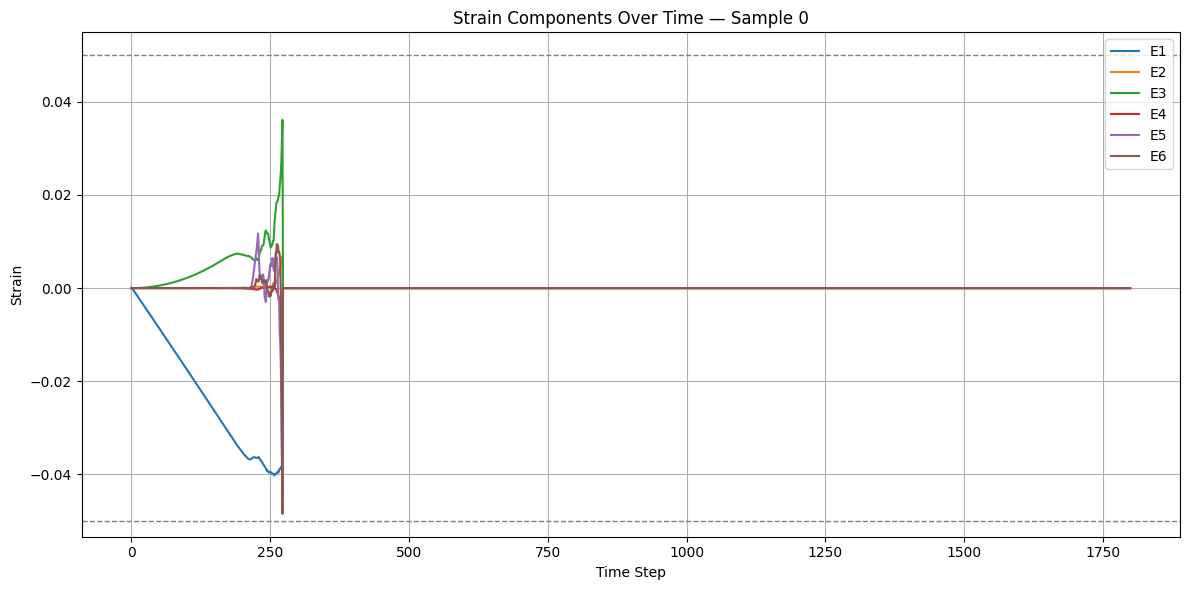

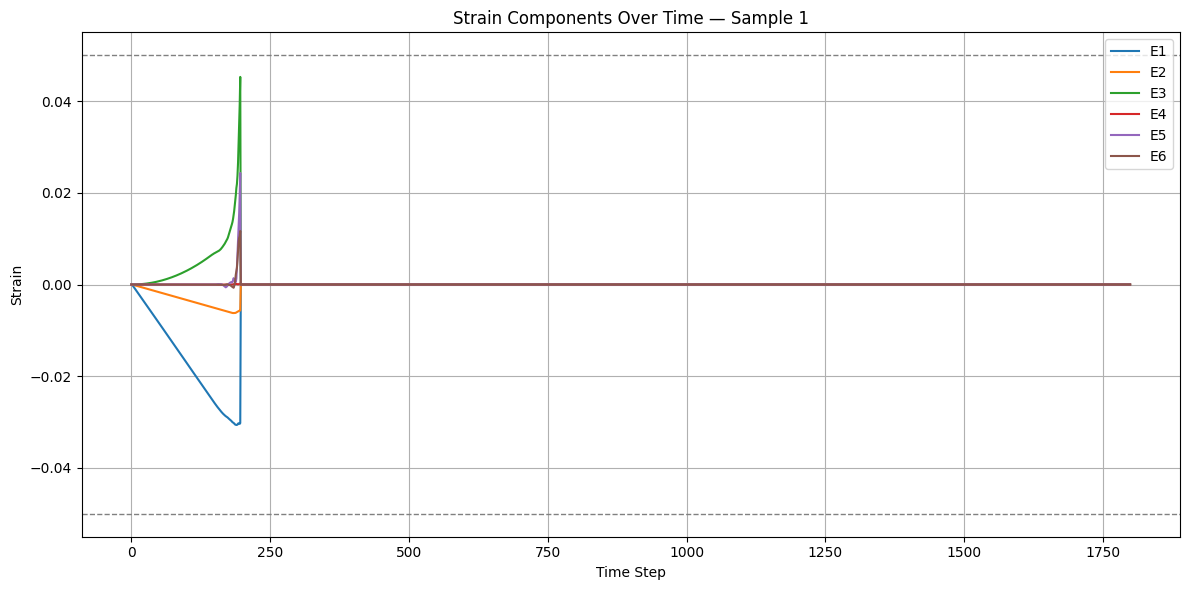

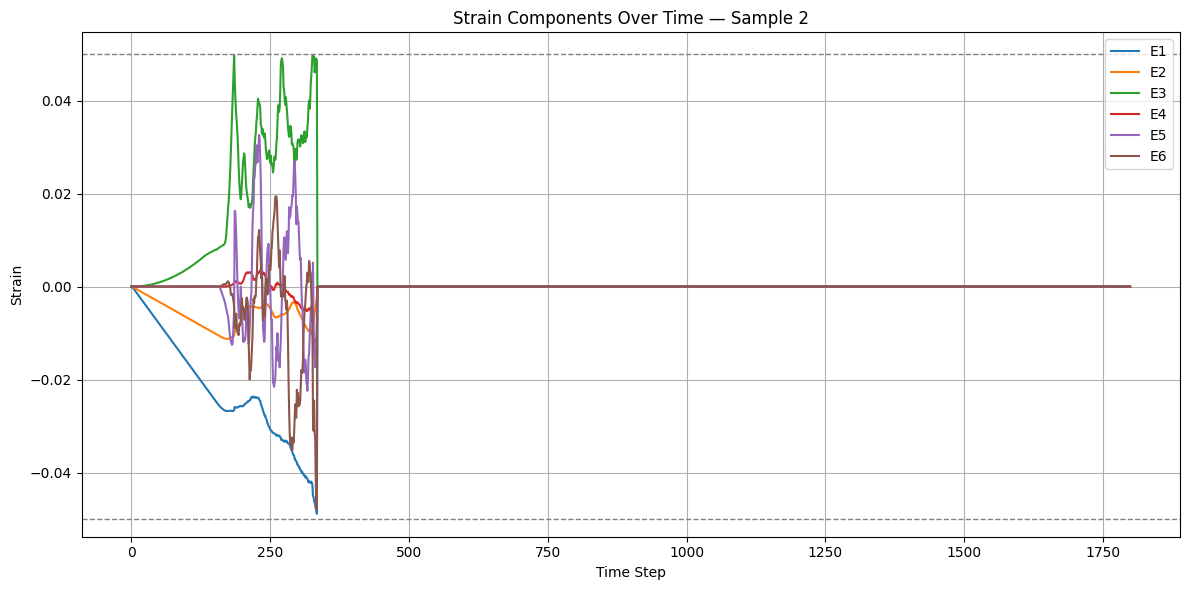

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def plot_strain_components(sample_input, sample_id=None, threshold=None):
    """
    Plot all 6 strain components (E1–E6) from a single sample.

    Args:
        sample_input (np.ndarray): Input sequence of shape [T, 11]
        sample_id (int or str, optional): ID for labeling the plot
        threshold (float, optional): Optional horizontal threshold lines
    """
    time_steps = np.arange(sample_input.shape[0])
    strain_data = sample_input[:, :6]  # E1–E6

    plt.figure(figsize=(12, 6))
    for i in range(6):
        plt.plot(time_steps, strain_data[:, i], label=f'E{i+1}')
    
    if threshold:
        plt.axhline(y=threshold, color='gray', linestyle='--', linewidth=1)
        plt.axhline(y=-threshold, color='gray', linestyle='--', linewidth=1)

    title = f"Strain Components Over Time — Sample {sample_id}" if sample_id is not None else "Strain Components Over Time"
    plt.title(title)
    plt.xlabel("Time Step")
    plt.ylabel("Strain")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 🔍 Plot a few filtered samples
for i in [0, 1, 2]:
    plot_strain_components(inputs_filtered[i], sample_id=i, threshold=strain_threshold)

## Test: Global vs. Selective Strain Thresholding

We will now test both updated functions:
- `load_time_series()`: which supports both global and per-component thresholds
- `load_all_data()`: now accepts a `component_thresholds` dictionary

### Goals:
- Compare dataset sizes and input statistics using:
  - A **global ±5% threshold** (baseline)
  - A **selective threshold** (±10% for E5–E6 only)
- Ensure both methods return sequences of correct shape
- Verify that per-component filtering is applied correctly


In [24]:
# Baseline test with global ±5% filtering
from utils_parsing import load_all_data

baseline_inputs, baseline_targets = load_all_data(
    input_csv_path=input_csv_path,
    data_dir=data_dir,
    max_seq_len=1800,
    strain_threshold=0.05,  # Global threshold
    min_timesteps=20,
    component_thresholds=None  # Explicitly test the default path
)

print("Global Threshold Test (±5%)")
print(f"Samples loaded: {len(baseline_inputs)}")
print(f"Example shape: Input {baseline_inputs[0].shape}, Target {baseline_targets[0].shape}")

Global Threshold Test (±5%)
Samples loaded: 1848
Example shape: Input (1800, 11), Target (1800, 6)


In [25]:
# Selective threshold: apply ±0.1 to E5 and E6, ±0.05 to E1–E4
custom_thresholds = {
    0: 0.05,  # E1
    1: 0.05,  # E2
    2: 0.05,  # E3
    3: 0.05,  # E4
    4: 0.10,  # E5
    5: 0.10   # E6
}

selective_inputs, selective_targets = load_all_data(
    input_csv_path=input_csv_path,
    data_dir=data_dir,
    max_seq_len=1800,
    min_timesteps=20,
    component_thresholds=custom_thresholds
)

print("Selective Threshold Test (E5–E6 ±10%, E1–E4 ±5%)")
print(f"Samples loaded: {len(selective_inputs)}")
print(f"Example shape: Input {selective_inputs[0].shape}, Target {selective_targets[0].shape}")

Selective Threshold Test (E5–E6 ±10%, E1–E4 ±5%)
Samples loaded: 1848
Example shape: Input (1800, 11), Target (1800, 6)


In [26]:
import numpy as np

# Custom thresholds applied during loading
component_thresholds = {
    0: 0.05,  # E1
    1: 0.05,  # E2
    2: 0.05,  # E3
    3: 0.05,  # E4
    4: 0.10,  # E5
    5: 0.10   # E6
}

# Track violations
violations = []
total_checked = 0

# Loop through each sample
for sample_idx, input_seq in enumerate(selective_inputs):
    # Extract strain components (E1–E6 only)
    strain = input_seq[:, :6]  # shape: [T, 6]

    # Remove padded rows (assuming padding is zero)
    valid_rows = ~np.all(input_seq == 0, axis=1)
    strain = strain[valid_rows]

    # Check each conditioned component
    for comp_idx, threshold in component_thresholds.items():
        exceeded = np.abs(strain[:, comp_idx]) > threshold
        if np.any(exceeded):
            violations.append((sample_idx, comp_idx, strain[exceeded][:5]))  # Log first 5 violations
    total_checked += 1

# Summary
print(f"Checked {total_checked} samples with selective thresholds.")
print(f"Violating samples found: {len(violations)}")

# Optionally preview the first few violations
if violations:
    print("\nSample violations (sample index, component index, example values):")
    for v in violations[:5]:
        print(v)
else:
    print("All strain values comply with their respective thresholds.")

Checked 1848 samples with selective thresholds.
Violating samples found: 0
All strain values comply with their respective thresholds.


### 🧪 Sanity Check: Dataset Splitting Logic

We verify that the train/val split logic correctly:
- Loads mutually exclusive subsets
- Maintains consistent splits across runs (via fixed seed)
- Covers the full dataset without overlap

This test uses:
- `split='train'` and `split='val'` with the same `split_ratio` and `seed`
- Set operations to check overlap

In [28]:
from dataloader import get_dataloader

# Constants
INPUT_CSV = "../data/IM78552_DATABASEInput.csv"
DATA_DIR = "../data/_CSV"
BATCH_SIZE = 32
MAX_SEQ_LEN = 1800
SPLIT_RATIO = 0.8
SEED = 42

# Load train and val loaders with same seed
train_loader = get_dataloader(INPUT_CSV, DATA_DIR, MAX_SEQ_LEN, BATCH_SIZE, split='train', split_ratio=SPLIT_RATIO, seed=SEED)
val_loader   = get_dataloader(INPUT_CSV, DATA_DIR, MAX_SEQ_LEN, BATCH_SIZE, split='val',   split_ratio=SPLIT_RATIO, seed=SEED)

# Get sample indices from Subset objects
train_indices = set(train_loader.dataset.indices)
val_indices   = set(val_loader.dataset.indices)

# Sanity checks
print(f"Total samples     : {len(train_indices | val_indices)}")
print(f"Train set size    : {len(train_indices)}")
print(f"Validation set size: {len(val_indices)}")
print(f"Overlap detected  : {len(train_indices & val_indices)}")

# Expect:
# - Total = Full dataset
# - Overlap = 0

Total samples     : 1848
Train set size    : 1478
Validation set size: 370
Overlap detected  : 0
